# A plane wave on a square

We solve the two-dimensional wave equation to find $H: [0,T]\to H^1(\Omega)$ and the vector field $E: [0,T]\to H(\mathrm{div})$ are

$$
\begin{aligned}
\partial_t E(t,x)   &= -\nabla H(t,x),&t\in(0,T),x\in\Omega\\
\partial_t H(t,x)&= -\mathrm{div} E(t,x) + f(t,x),&t\in(0,T),x\in\Omega\\
H(0,x) &= \exp(-400(y-1/2)^2),&t\in(0,T),x\in\Omega\\
E(0,x) &= 0,&x\in\Omega\\
H(t,x) &= 0,&t\in(0,T),x\in\partial\Omega
\end{aligned}
$$
for $\Omega=(0,1)^2$.


In [1]:
from ngsolve import *
import dualcellspaces as dcs
from time import time
from ngsolve.webgui import Draw

After the necessary imports we define some parameters and the mesh

In [2]:
maxh = 0.03
tend = 2
order = 2

H0 = CF(exp(-20**2*((y-1/2)**2)))
E0 = CF((0,0))

mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
Draw(mesh);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

We define the spaces

In [3]:
fesH = dcs.H1DualCells(mesh, order=order)
fesE = dcs.HDivPrimalCells(mesh, order=order)

To define the (Mass) bilinear forms we need special integration rules:

In [4]:
E, dE = fesE.TnT()
H, dH = fesH.TnT()

dxH = dx(intrules=fesH.GetIntegrationRules())
dSw = dx(element_boundary=True,intrules=dcs.GetIntegrationRules(2*order+6))
dxw = dx(intrules=dcs.GetIntegrationRules(2*order+6))


massE = fesE.Mass(Id(2))
massH = fesH.Mass(1)
massinvE = massE.Inverse()
massinvH = massH.Inverse()

normal = specialcf.normal(2)

Grad = BilinearForm(-H*div(dE)*dxw+H*dE*normal*dSw, geom_free=True).Assemble().mat

lffH = LinearForm(dH*H0*dxH).Assemble()

The maximal admissible time step may be estimated using a simple power iteration

In [5]:
def estimate_tau(mat, maxsteps = 1000, tol = 1e-4):   
    vec = mat.CreateColVector()
    vec.SetRandom()
    tmp = vec.CreateVector()
    lam = 0
    for i in range(maxsteps):
        #print(i,end='\r')
        tmp.data = mat * vec
        
        lamnew = InnerProduct(tmp,vec)
        tau = 2/sqrt(lamnew)
        #res=(lamnew*vec-tmp).Norm()
        tmp *= 1/tmp.Norm()
        #print(lamnew)
        diff = (tmp-vec).Norm()
        if diff<tol: return tau
        vec.data = tmp
        lam = lamnew
    print("did not converge, last diff = ",diff)
    return tau

In [6]:
tau = estimate_tau(massinvH@Grad.T@massinvE@Grad)

print("estimated timestep tau: {:e}".format(tau))
tau*=0.9

estimated timestep tau: 1.438193e-03


It remains to set the initial conditions...

In [7]:
t = 0.
i = 0
drawevery = 30

gfE = GridFunction(fesE)
gfH = GridFunction(fesH)

gfH_history = GridFunction(fesH,multidim=0)

gfH.vec.data = massinvH*lffH.vec
gfE.vec.data[:] = 0.

#scene = Draw(gfH,mesh,intpoints=dcs.GetWebGuiPoints(2),order=2,autoscale=False,min=0,max=1)

gfE.vec.data = tau/2*massinvE@Grad*gfH.vec

... and start the time loop

In [8]:

now = time()
nowstart = now

times = []
energies = []
tmpH = gfH.vec.CreateVector()
tmpE = gfE.vec.CreateVector()
subtime = 0
with TaskManager():
    while t<tend:
        if i%drawevery == 0:
            timepassed = time()-now
            before_energy_time = time()
            gfH_history.AddMultiDimComponent(gfH.vec)
            #scene.Redraw()
            times.append(t)
            tmpH.data = massH * gfH.vec
            tmpE.data = massE * gfE.vec
            energies.append(InnerProduct(gfE.vec,tmpE)+InnerProduct(gfH.vec,tmpH))
            #print("\r time = {}\t step = {}\t energy = {}\t current dofs/s = {:e}".format(t,i,energies[-1],(fesE.ndof+fesH.ndof)*drawevery/timepassed),end="")
            subtime += time()-before_energy_time
            now = time()
        i=i+1
        t+=tau
        gfH.vec.data += -tau*massinvH@Grad.T*gfE.vec
        gfE.vec.data += tau*massinvE@Grad*gfH.vec

comptime = time()-nowstart-subtime
print("\n timesteps: {}\t dofs: {}\t dofs per second: {:e}".format(tend/tau, (fesE.ndof+fesH.ndof),(fesE.ndof+fesH.ndof)*tend/tau/comptime))


 timesteps: 1545.1491700646156	 dofs: 162256	 dofs per second: 1.157738e+08


In [9]:
scene = Draw(gfH_history,mesh,intpoints=dcs.GetWebGuiPoints(2),order=2,autoscale=False,min=0,max=1,animate=True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

We observe preservation of a modified (discrete) energy:

(0.0, 0.1)

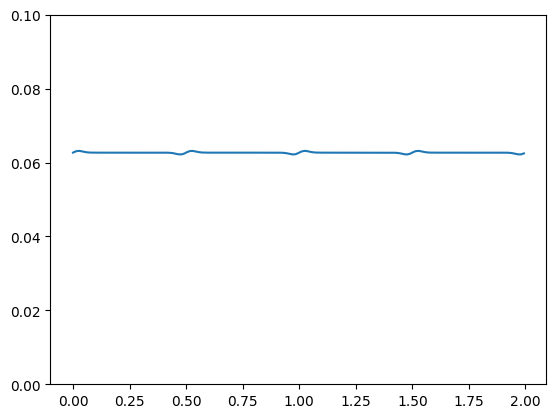

In [11]:
import matplotlib.pyplot as pl
pl.plot(times,energies);
pl.ylim((0,0.1));